# Classification Modeling - Update

# Imports

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

## Import modeling tools, pipelines, models, and metrics
# import shap

In [2]:
# from sklearnex import patch_sklearn
# patch_sklearn()

In [3]:
from sklearn.metrics import classification_report, ConfusionMatrixDisplay
from sklearn import set_config
from sklearn.compose import ColumnTransformer
from sklearn.dummy import DummyClassifier
from sklearn.ensemble import HistGradientBoostingClassifier, RandomForestClassifier
from sklearn.impute import SimpleImputer
from sklearn.inspection import permutation_importance
from sklearn.model_selection import cross_val_predict, cross_val_score, GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import StratifiedKFold, train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder

set_config(transform_output='pandas')

# Load Data

In [4]:
df_data = pd.read_parquet('../../data/3.2_data_with_occupancies.parquet')
df_data

,IsCanceled,LeadTime,ArrivalDateYear,ArrivalDateMonth,ArrivalDateWeekNumber,ArrivalDateDayOfMonth,Adults,Children,Babies,Meal,...,Fourier_Annual_Sin_2,Fourier_Annual_Cos_2,Fourier_Annual_Sin_3,Fourier_Annual_Cos_3,Fourier_Monthly_Sin_2,Fourier_Monthly_Cos_2,occupancy_at_arrival,occupancy_at_departure,occupancy_pct_at_arrival,occupancy_pct_at_departure
0,0,342,2015,July,27,1,2,0.0,0,BB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,41,0.115169,0.115169
56,0,149,2015,July,27,1,2,1.0,0,BB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,201,0.115169,0.564607
57,0,149,2015,July,27,1,2,0.0,0,BB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,201,0.115169,0.564607
58,0,145,2015,July,27,1,2,0.0,0,HB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,201,0.115169,0.564607
59,0,110,2015,July,27,1,3,0.0,0,BB,...,0.000000,1.000000,0.000000,1.00000,0.000000,1.000000,41,172,0.115169,0.483146
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
119362,0,4,2017,August,35,31,2,0.0,0,SC,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,102,0.761236,0.286517
119366,0,198,2017,August,35,31,2,0.0,0,SC,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,154,0.761236,0.432584
119372,0,332,2017,August,35,31,2,0.0,0,BB,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,154,0.761236,0.432584
119380,0,109,2017,August,35,31,2,0.0,0,BB,...,0.855075,-0.518505,-0.032249,-0.99948,0.229128,0.973396,271,22,0.761236,0.061798


In [5]:
df_data.columns.to_list()

['IsCanceled',
 'LeadTime',
 'ArrivalDateYear',
 'ArrivalDateMonth',
 'ArrivalDateWeekNumber',
 'ArrivalDateDayOfMonth',
 'Adults',
 'Children',
 'Babies',
 'Meal',
 'Country',
 'MarketSegment',
 'DistributionChannel',
 'IsRepeatedGuest',
 'PreviousCancellations',
 'PreviousBookingsNotCanceled',
 'ReservedRoomType',
 'AssignedRoomType',
 'BookingChanges',
 'DepositType',
 'Agent',
 'Company',
 'DaysInWaitingList',
 'CustomerType',
 'ADR',
 'RequiredCarParkingSpaces',
 'TotalOfSpecialRequests',
 'ReservationStatus',
 'HotelNumber',
 'ArrivalDate',
 'DepartureDate',
 'Length of Stay',
 'BookingDate',
 'ArrivalDate_DaysAfterHoliday',
 'ArrivalDate_DaysBeforeHoliday',
 'DepartureDate_DaysAfterHoliday',
 'DepartureDate_DaysBeforeHoliday',
 'BookingDate_DaysAfterHoliday',
 'BookingDate_DaysBeforeHoliday',
 'ArrivalDate_IsHoliday',
 'DepartureDate_IsHoliday',
 'BookingDate_IsHoliday',
 'ArrivalDate_Season',
 'ArrivalDate_DayOfWeek',
 'ArrivalDate_IsWeekend',
 'ArrivalDate_DaysUntilWeekend',
 

In [6]:
df_data = df_data.drop(columns=['ArrivalDate', 'DepartureDate','ReservationStatus', 'DepartureDate'])

In [7]:
# selected_features = ['LeadTime',
#  'ArrivalDateYear',
#  'ArrivalDateMonth',
#  'ArrivalDateWeekNumber',
#  'ArrivalDateDayOfMonth',
#  'Adults',
#  'Children',
#  'Babies',
#  'Meal',
#  'Country',
#  'MarketSegment',
#  'DistributionChannel',
#  'IsRepeatedGuest',
#  'PreviousCancellations',
#  'PreviousBookingsNotCanceled',
#  'ReservedRoomType',
#  'AssignedRoomType',
#  'BookingChanges',
#  'DepositType',
#  'Agent',
#  'Company',
#  'DaysInWaitingList',
#  'CustomerType',
#  'ADR',
#  'RequiredCarParkingSpaces',
#  'TotalOfSpecialRequests',
#  'ReservationStatus',
#  'HotelNumber',
#  'ArrivalDate',
#  'DepartureDate',
#  'Length of Stay',
#  'BookingDate',
#  'ArrivalDate_DaysBeforeHoliday',
#  'ArrivalDate_DaysAfterHoliday',
#  'DepartureDate_DaysBeforeHoliday',
#  'DepartureDate_DaysAfterHoliday',
#  'BookingDate_DaysBeforeHoliday',
#  'BookingDate_DaysAfterHoliday',
#  'ArrivalDate_DayOfWeek',
#  'occupancy_at_arrival',
#  'occupancy_at_departure',
#  'occupancy_pct_at_arrival',
#  'occupancy_pct_at_departure']

In [8]:
# df_data = df_data[selected_features]
# df_data

# Train/Test Split

In [9]:
target_feature = 'IsCanceled'

X = df_data.drop(columns=target_feature)
y = df_data[target_feature]

X_train, X_test, y_train, y_test = train_test_split(X,
                                                    y,
                                                    random_state = 42,
                                                    stratify=y)

In [10]:
y_train.value_counts(normalize=True).round(2)

IsCanceled
0    0.63
1    0.37
Name: proportion, dtype: float64

In [11]:
y_test.value_counts(normalize=True).round(2)

IsCanceled
0    0.63
1    0.37
Name: proportion, dtype: float64

# Random Forest Classifer Model Without Tuning

In [20]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=10,
                                                   max_categories = 30))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced_subsample',
                                                                       max_depth=50))])

model_pipeline.fit(X_train, y_train)

## Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

## Evaluate the model using cross_val_score
cv_scores = cross_val_score(model_pipeline, X, y, cv=skf)#, scoring='f1', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')


Cross-Validation Scores: [0.89056872 0.88994053 0.89186699 0.89609683 0.89077812]
Mean CV Score: 0.892
Standard Deviation of CV Scores: 0.002



## Model Results

              precision    recall  f1-score   support

           0       0.89      0.94      0.92     75166
           1       0.89      0.80      0.85     44224

    accuracy                           0.89    119390
   macro avg       0.89      0.87      0.88    119390
weighted avg       0.89      0.89      0.89    119390



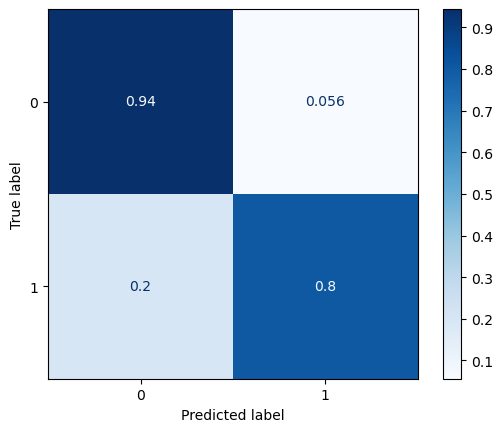

In [21]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

### Tree Depths

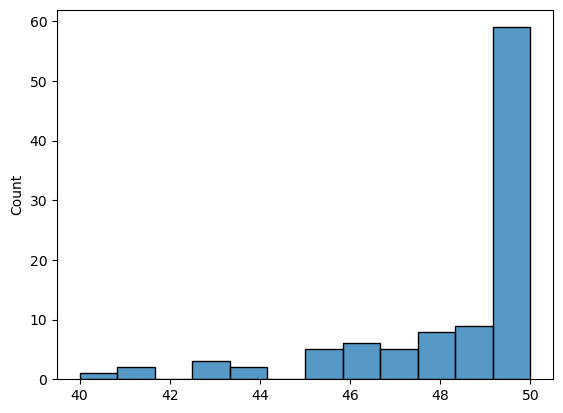

In [22]:
# Access the fitted model
fitted_model = model_pipeline[-1]

# Get the depths of the trees in the fitted model
depths = [tree.get_depth() for tree in fitted_model.estimators_]

# Plot the histogram of tree depths
sns.histplot(depths);

# Random Forest Classifer Model with Tuning

In [ ]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## Create separate pipelines for categorical and numeric features

cat_pipeline = Pipeline([('imputer', SimpleImputer(strategy = 'most_frequent')),
                         ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                                                   sparse_output=False,
                                                   min_frequency=10,
                                                   max_categories = 50))])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean'))
])

## Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[('num', num_pipeline, num_feats),
                                               ('cat', cat_pipeline, cat_feats)])

## Build the full pipeline
model_pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                                 ('classifier', RandomForestClassifier(class_weight='balanced_subsample'))])

# Set up hyperparameter tuning 
param_grid = {
    'preprocessor__cat__encoder__min_frequency': [10, 25],
    'preprocessor__cat__encoder__max_categories': [50, 100],
    'classifier__max_depth': [40, 60],
    'classifier__min_samples_split': [2, 3],
    'classifier__min_samples_leaf': [1, 2],
    'classifier__class_weight': ['balanced', 'balanced_subsample']
}

# Define the stratified k-fold cross-validator
skf = StratifiedKFold(n_splits=5, shuffle = True, random_state = 42)

search = RandomizedSearchCV(model_pipeline,
                            param_distributions=param_grid,
                            scoring='f1',
                            cv=skf,
                            n_iter=30,
                            n_jobs=-1,
                            random_state=42)

# Fit the model and find the best hyperparameters
search.fit(X_train, y_train)

# Extract the best model
best_model = search.best_estimator_

# Evaluate the best model using cross_val_score
cv_scores = cross_val_score(best_model, X, y, scoring='f1', n_jobs=-1)

print(f'\nCross-Validation Scores: {cv_scores}\n'
      f'Mean CV Score: {cv_scores.mean():,.3f}\n'
      f'Standard Deviation of CV Scores: {cv_scores.std():,.3f}\n')

## RFC Model w/ Tuning Results

### Scoring

In [ ]:
y_pred = cross_val_predict(model_pipeline, X, y, cv=skf, n_jobs=-1)

print(classification_report(y, y_pred))

ConfusionMatrixDisplay.from_predictions(y, y_pred, cmap='Blues', normalize='true');

### Permutation Importances

In [ ]:
# Calculate permutation importances
result = permutation_importance(best_model,
                                X_test, 
                                y_test,
                                n_jobs=-1,
                                scoring = 'f1')

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - RFC

In [ ]:
X_train_xf = best_model.named_steps.preprocessor.fit_transform(X_train)
X_test_xf = best_model.named_steps.preprocessor.transform(X_test)

In [ ]:
X_shap_train = shap.sample(X_train_xf, 500)
y_shap_train = y_train.loc[X_shap_train.index]

X_shap_test = shap.sample(X_test_xf, 500)
y_shap_test = y_test.loc[X_shap_test.index]

In [ ]:
explainer = shap.Explainer(best_model.named_steps.classifier, X_shap_train)
# shap_values_train = explainer(X_shap_train)
shap_values_test = explainer(X_shap_test)

In [ ]:
# print(shap_values_train.shape)
print(shap_values_test.shape)

### Summary Plot

In [ ]:
shap.summary_plot(shap_values_test[:, :, 0], X_shap_train)

In [ ]:
# df_data.groupby(['Country'])[['ReservationStatus']].value_counts(normalize=True).loc['PRT']

### Force Plot

In [ ]:
# For multiple predictions
# shap.force_plot(explainer.expected_value[0], shap_values[0], X_test)

# `HistGradientBoostingClassifier` Approach

In [ ]:
# Select categorical and numerical features
cat_feats = X.select_dtypes(include=['object']).columns
num_feats = X.select_dtypes(include=['number']).columns

## --- Create separate pipelines for categorical and numeric features --- ##

# Create separate pipelines for categorical and numeric features
cat_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='most_frequent')),
    ('encoder', OneHotEncoder(handle_unknown='infrequent_if_exist',
                              sparse_output=False,
                              max_categories=200))
])

num_pipeline = Pipeline([
    ('imputer', SimpleImputer(strategy='mean')),
    # ('yeojohnson', PowerTransformer(method='yeo-johnson')),
    # ('scaler', StandardScaler())
])

# Combine transformers into a single ColumnTransformer
preprocessor = ColumnTransformer(transformers=[
    ('num', num_pipeline, num_feats),
    ('cat', cat_pipeline, cat_feats)
])

# Create the RandomForestClassifier model
classifier = HistGradientBoostingClassifier(class_weight='balanced',
                                            scoring = 'f1_weighted')

hgbr_model_pipeline = Pipeline(steps=[
    ('preprocessor', preprocessor),
    ('classifier', classifier)
])

# Use joblib for parallel processing
with parallel_backend('loky', n_jobs=-1):
    
    # Fit the model and generate predictions
    hgbr_model_pipeline.fit(X_train, y_train)

hgbr_y_pred = hgbr_model_pipeline.predict(X_test)

# Evaluate performance metrics
hgbr_score_training = hgbr_model_pipeline.score(X_train, y_train)
hgbr_score_testing = hgbr_model_pipeline.score(X_test, y_test)

In [ ]:
classification_results(model_pipeline = hgbr_model_pipeline,
                       X_train = X_train,
                       X_test = X_test,
                       y_train = y_train,
                       y_test = y_test);

In [ ]:
# Calculate permutation importances
result = permutation_importance(hgbr_model_pipeline,X_test, y_test,n_jobs=-1)

# Extract importances and standard deviations
perm_importances = result.importances_mean
perm_importances_std = result.importances_std

# Create a DataFrame for easy plotting
importance_df = pd.DataFrame({
    'Feature': X.columns,
    'Importance': perm_importances,
    'Importance_std': perm_importances_std
}).sort_values(by='Importance', ascending=False).reset_index(drop=True)

# Plot the feature importances
sns.barplot(x='Importance', y='Feature',data=importance_df[:10]);

## SHAP - HGBR

In [ ]:
X_train_xf = hgbr_model_pipeline.named_steps.preprocessor.fit_transform(X_train)
X_train_xf

In [ ]:
X_shap = shap.sample(X_train_xf, 10000)
X_shap

In [ ]:
y_shap = y_train.loc[X_shap.index]
y_shap

In [ ]:
hgbr_model_pipeline

In [ ]:
# explainer = shap.Explainer(hgbr_model_pipeline.named_steps.classifier, X_shap)
explainer = shap.Explainer(hgbr_model_pipeline.named_steps['classifier'])
shap_values = explainer(X_shap)
shap_values.shape

## Summary Plot

In [ ]:
shap.summary_plot(shap_values, X_shap)

# Results and Recommendations

Based on the SHAP results, **we can infer characteristics of guests who are less likely to cancel their reservations.** These characteristics can help define the target market for the hotels to minimize cancellations. Here's an example of an ideal target market:

## Target Market for Minimizing Hotel Reservation Cancellations

1. **Length of Stay**:
   - **Profile**: Guests who book longer stays.
   - **Reason**: Longer stays are associated with a lower likelihood of cancellation.

2. **Days Since Booking**:
   - **Profile**: Guests who book well in advance.
   - **Reason**: A higher number of days since booking indicates a lower likelihood of cancellation.

3. **Deposit Type**:
   - **Profile**: Guests willing to make non-refundable deposits.
   - **Reason**: Non-refundable deposits significantly reduce the likelihood of cancellation.

4. **Country of Origin**:
   - **Profile**: Guests from specific countries like Portugal (PRT).
   - **Reason**: Guests from certain countries show a lower likelihood of cancellation.

5. **Market Segment**:
   - **Profile**: Guests booking through Online Travel Agents (OTA).
   - **Reason**: Bookings through OTAs are less likely to be canceled.


## Example Target Market Persona:

### **1. Business Traveler:**
- **Length of Stay**: 4-7 days
- **Booking Time**: At least 2-3 months in advance
- **Deposit**: Non-refundable
- **Country**: Portugal (PRT) or other identified low-cancellation countries
- **Booking Channel**: Online Travel Agent (OTA)
- **Travel Period**: Not immediately before or after major holidays
- **Customer Type**: Individual transient
- **Booking Changes**: Minimal to no changes post-booking

### **2. Family Vacationers:**
- **Length of Stay**: 5-10 days
- **Booking Time**: 3-6 months in advance
- **Deposit**: Non-refundable
- **Country**: Identified low-cancellation countries (e.g., Portugal)
- **Booking Channel**: OTA or direct website booking
- **Travel Period**: Booking dates that avoid peak holiday disruptions
- **Customer Type**: Transient, not part of group deals
- **Booking Changes**: Stable itinerary with few changes

## Marketing Strategies:

1. **Early Bird Promotions**: Encourage early bookings with attractive discounts for longer stays.
2. **Non-Refundable Deposit Discounts**: Offer special rates for bookings with non-refundable deposits.
3. **Country-Specific Campaigns**: Tailor marketing efforts towards countries with lower cancellation rates.
4. **OTA Partnerships**: Strengthen relationships with online travel agents to attract more reliable bookings.
5. **Holiday Package Adjustments**: Optimize packages and promotions to avoid booking peaks right before or after holidays.
6. **Loyalty Programs for Transient Guests**: Create loyalty programs that cater to individual transient travelers with stable travel plans.
7. **Agent Performance Monitoring**: Monitor and incentivize agents with better non-cancellation records to maintain quality bookings.

By focusing on these customer profiles and implementing targeted marketing strategies, the hotel can effectively reduce reservation cancellations and optimize their booking stability.